<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/im2spec_VED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *im2spec*: Predicting functional response from structural data 


---
This notebook demonstrates how one can predict spectra from structural images via encoding of the observed geometries to a small number of latent variables and subsequently decoding them into spectra.

---

Prepared by Maxim Ziatdinov

Email: ziatdinovmax@gmail.com





Installation:

In [ ]:
!pip install -q pyroved

Download training data:

In [ ]:
!gdown https://drive.google.com/uc?id=1BprChho_y-LdVQstR1vYzCxmK677algR

Downloading...
From: https://drive.google.com/uc?id=1BprChho_y-LdVQstR1vYzCxmK677algR
To: /content/EELS_plasmonic_1.npz
50.1MB [00:00, 159MB/s]


Imports:

In [ ]:
import pyroved as pv

import torch
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, MeanShift

We start by loading data into the notebook. The data contains scanning transmission electron microscopy (STEM) image patches of local geometries of plasmonic nanoparticles ("features") and the associated electron energy-loss spectroscopy (EELS) spectra ("targets"). We also show a "mother" image from which the image patches were extracted. The experimental STEM and EELS data was collected by Jordan Hachtel and Kevin Roccapriore at Oak Ridge National Laboratory.

In [ ]:
dataset = np.load("EELS_plasmonic_1.npz")
features = dataset["images"]
targets = dataset["spectra"]
indices = dataset["indices"]
full_img = dataset["full_image"]
print(features.shape, targets.shape)

(2714, 16, 16) (2714, 2048)


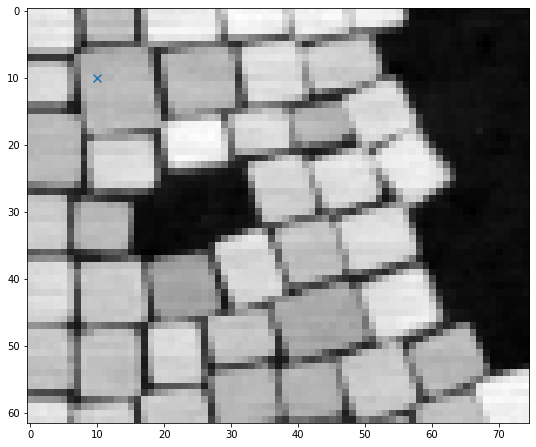

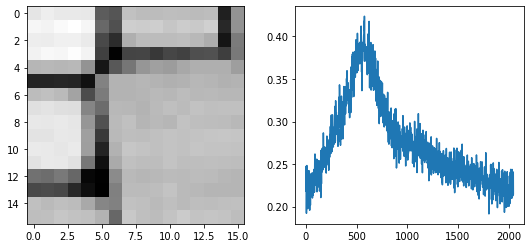

In [ ]:
k = 120

plt.figure(figsize=(9, 9))
plt.imshow(full_img, cmap='gray')
plt.scatter(indices[k,1], indices[k,0], marker='x', s=64)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(features[k], cmap='gray')
ax2.plot(targets[k])  # here we disregard the actual x-axis values

Here we normalize the data, add explicitly a channel dimension, and then split into train and test sets:

In [ ]:
norm_ = lambda x: torch.from_numpy((x - x.min()) / (x.max() - x.min())).float()
features, targets = norm_(features[:, None]), norm_(targets[:, None])
(features, features_test, targets, targets_test,
 indices, indices_test) = train_test_split(
    features, targets, indices, test_size=0.15, shuffle=True, random_state=1)

Initilize a dataloader:

In [ ]:
train_loader = pv.utils.init_dataloader(features, targets)

Initialize and train an *im2spec* model:

In [ ]:
# Specify input and output dimensions
in_dim = (16, 16)  # images height and width
out_dim = (2048,)  # length of spectra

# Initialize model
ved = pv.models.VED(in_dim, out_dim, sampler_d="bernoulli")

# Initialize trainer
trainer = pv.trainers.SVItrainer(ved)

# Train for n epochs
for _ in range(100):
    trainer.step(train_loader, scale_factor=4) # use a scale factor for KL divergence term to improve disentanglement
    trainer.print_statistics()

/usr/local/lib/python3.7/dist-packages/pyroved/nets/conv.py:172: UserWarning: 'bilinear' mode is not supported for 1D and 3D; switching to 'nearest' mode
  warn(warn_msg, category=UserWarning)


Epoch: 1 Training loss: 1083.3525
Epoch: 2 Training loss: 928.1907
Epoch: 3 Training loss: 921.4869
Epoch: 4 Training loss: 919.7981
Epoch: 5 Training loss: 918.9773
Epoch: 6 Training loss: 917.6675
Epoch: 7 Training loss: 914.2681
Epoch: 8 Training loss: 911.8355
Epoch: 9 Training loss: 910.8152
Epoch: 10 Training loss: 908.7010
Epoch: 11 Training loss: 907.7912
Epoch: 12 Training loss: 906.3681
Epoch: 13 Training loss: 905.8477
Epoch: 14 Training loss: 905.2300
Epoch: 15 Training loss: 904.8729
Epoch: 16 Training loss: 904.7765
Epoch: 17 Training loss: 904.9632
Epoch: 18 Training loss: 904.3661
Epoch: 19 Training loss: 903.9629
Epoch: 20 Training loss: 903.7593
Epoch: 21 Training loss: 903.8015
Epoch: 22 Training loss: 903.8761
Epoch: 23 Training loss: 903.5694
Epoch: 24 Training loss: 903.8236
Epoch: 25 Training loss: 903.5495
Epoch: 26 Training loss: 903.5628
Epoch: 27 Training loss: 903.6289
Epoch: 28 Training loss: 903.4392
Epoch: 29 Training loss: 903.2464
Epoch: 30 Training los

Plot the learned latent manifold (spectral domain):

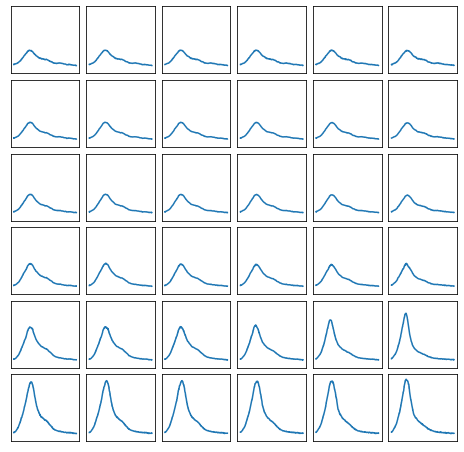

In [ ]:
ved.manifold2d(d=6, ylim=[0., .8], cmap='viridis');

Now let's encode *test* images into the latent space:

Text(0, 0.5, '$z_2$')

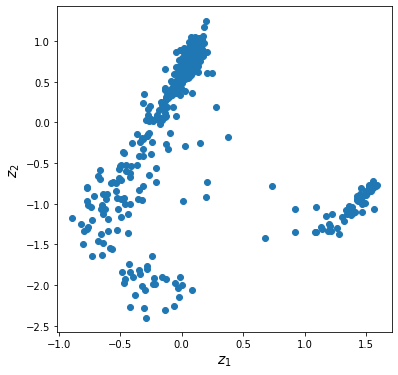

In [ ]:
z, _ = ved.encode(features_test)

plt.figure(figsize=(6, 6))
plt.scatter(z[:, 1], z[:, 0])
plt.xlabel("$z_1$", fontsize=14)
plt.ylabel("$z_2$", fontsize=14)

We can see that the encoded features form ~3-4 clusters. We can separate them using *e.g* a mean-shift clustering method:

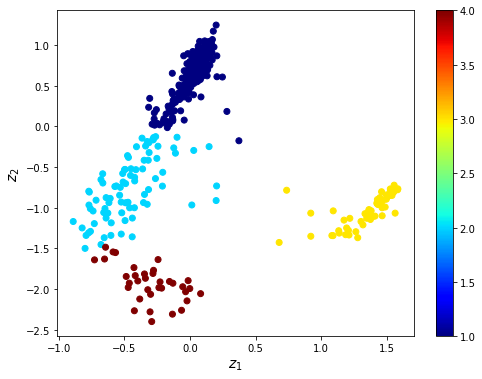

In [ ]:
clustering = MeanShift(bandwidth=0.5).fit(z)
labels = torch.from_numpy(clustering.labels_) + 1

plt.figure(figsize=(8, 6))
plt.scatter(z[:, 1], z[:, 0], c=labels, cmap='jet')
plt.xlabel("$z_1$", fontsize=14)
plt.ylabel("$z_2$", fontsize=14)
plt.colorbar();

Next, we decode spectra (using *im2spec*'s trained decoder) corresponding to the center of the mass for the four main clusters...

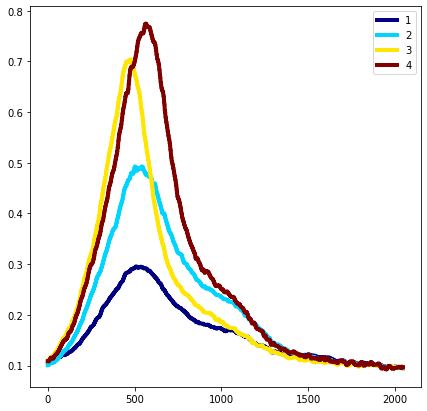

In [ ]:
cmap = mpl.cm.get_cmap('jet', len(labels.unique()))
_, ax = plt.subplots(figsize=(7, 7))
for i in labels.unique():
    zc = torch.mean((z[labels==i]), 0)
    xc = ved.decode(zc)
    ax.plot(xc.squeeze(), c=cmap(i.item()-1), lw=4, label=i.item())
plt.legend()

... and see which local structures these spectra are associated with:

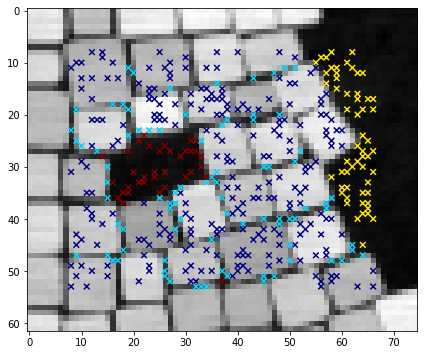

In [ ]:
plt.figure(figsize=(7, 7))
plt.imshow(full_img, cmap='gray')
plt.scatter(indices_test[:, 1], indices_test[:, 0], s=32,
            marker='x', c=labels, cmap='jet');

Clearly, the first clustered component corresponds to particles, the second one to the gaps between particles, the third one to the hole in the array, and the fourth one to the outside region. Comparing these results with the manual inspection of spectra confirms that the trained *im2spec* model was able to correctly correlate particles geometry with spectroscopic shapes.

Now let's make an *image* $\rightarrow$ *spectrum* prediction on the test data:

In [ ]:
pred_mean, pred_sd = ved.predict(features_test)

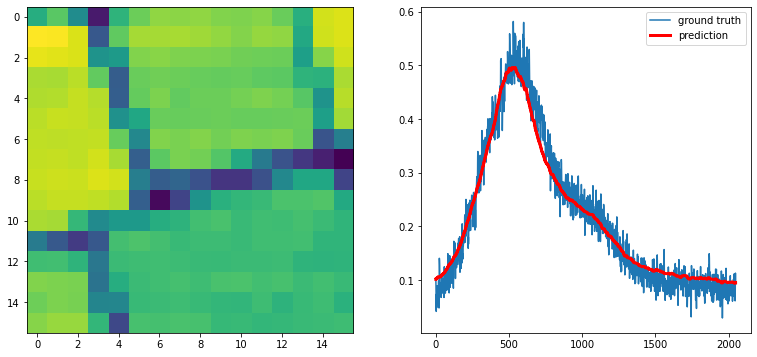

In [ ]:
k = 11

xseq = np.arange(0, 2048)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.imshow(features_test[k].squeeze())
ax2.plot(targets_test[k].squeeze(), label="ground truth", zorder=0)
ax2.plot(xseq, pred_mean[k].squeeze(), c='r', lw=3, label="prediction", zorder=1)
ax2.legend()

We see that the trained *im2spec* model both largely reproduces, both qualitative and quantitatively, the ground-truth spectrum solely from the local configuration of particles, demonstrating the capability of directly retrieving structure-property relationships.